# <center> Домашняя работа №4
## <center> Логистическая регрессия в задаче тегирования вопросов StackOverflow

**Надо вывести формулы, где это просится (да, ручка и бумажка), заполнить код в клетках и выбрать ответы в [веб-форме](https://docs.google.com/forms/d/100c3Ek94UL-VRwXrN4lxCSnGjfJrl6Gc96G21DNCh4w).**

## 0. Описание задачи

В этой домашней работе мы с вами изучим и запрограммируем модель для прогнозирования тегов по тексту вопроса на базе многоклассовой логистической регрессии. В отличие от обычной постановки задачи классификации (multiclass), в данном случае один пример может принадлежать одновременно к нескольким классам (multilabel). Мы будем реализовывать онлайн-версию алгоритма multilabel-классификации.

Мы будем использовать небольшую выборку из протеггированных вопросов с сайта StackOverflow размером в 125 тысяч примеров (около 150 Мб, скачайте по [этой](https://drive.google.com/open?id=0B4bl7YMqDnViYVo0V2FubFVhMFE) ссылке).

PS: Можно показать, что такая реализация совсем не эффективная и проще было бы использовать векторизированные вычисления. Для данного датасета так и есть. Но на самом деле подобные реализации используются в жизни, но естественно, написаны они не на Python. Например, в онлайн-моделях прогнозирования [CTR](https://en.wikipedia.org/wiki/Click-through_rate) юзеру показывается баннер, затем в зависимости от наличия клика происходит обновление параметров модели. В реальной жизни параметров модели может быть несколько сотен миллионов, а у юзера из этих ста миллионов от силы сто или тысяча параметров отличны от нуля, векторизировать такие вычисления не очень эффективно. Обычно все это хранится в огромных кластерах в in-memory базах данных, а обработка пользователей происходит распределенно.

PS2:
- в процессе решения домашней работы вам придется работать с текстом, и у вас может возникнуть желание сделать очевидный препроцессинг, например привести все слова в нижний регистр, в-общем **этого делать не нужно, если не оговорено заранее в задании**

In [5]:
#!pip install watermark
%load_ext watermark

Выведем версии используемых библиотек. Совпадут ли ответы в случае других версий - не гарантируется.

In [6]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.5.4
IPython 6.2.1

numpy 1.14.0
scipy 1.0.0
pandas 0.22.0
matplotlib 2.1.2
sklearn 0.19.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   :


In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm_notebook
import pandas as pd
from collections import defaultdict

# поменяйте на свой путь
DS_FILE_NAME = 'stackoverflow_sample_125k.tsv'
TAGS_FILE_NAME = 'top10_tags.tsv'

In [8]:
top_tags = []
with open(TAGS_FILE_NAME, 'r') as f:
    for line in f:
        top_tags.append(line.strip())
top_tags = set(top_tags)
print(top_tags)

{'html', 'java', 'jquery', 'android', 'php', 'python', 'javascript', 'c++', 'c#', 'ios'}


## 1. Многоклассовая логистическая регрессия

Вспомним, как получается логистическая регрессия для двух классов $\left\{0, 1\right\}$, вероятность принадлежности объекта к классу $1$ выписывается по теореме Байеса:

$$\large \begin{array}{rcl}
p\left(c = 1 \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right) + p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} \\
&=& \dfrac{1}{1 + e^{-a}} \\
&=& \sigma\left(a\right)
\end{array}$$
где:
- $\vec{x}$ – вектор признаков объекта
- $\sigma$ – обозначение функции логистического сигмоида при скалярном аргументе
- $a = \log \frac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} = \sum_{i=0}^M w_i x_i$ – это отношение мы моделируем линейной функцией от признаков объекта и параметров модели

Данное выражение легко обобщить до множества из $K$ классов, изменится только знаменатель в формуле Байеса. Запишем вероятность принадлежности объекта к классу $k$:
$$\large \begin{array}{rcl}
p\left(c = k \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = k\right)p\left(c = k\right)}{\sum_{i=1}^K p\left(\vec{x} \mid c = i\right)p\left(c = i\right)} \\
&=& \dfrac{e^{z_k}}{\sum_{i=1}^{K}e^{z_i}} \\
&=& \sigma_k\left(\vec{z}\right)
\end{array}$$
где:
- $\sigma_k$ – обозначение функции softmax при векторном аргументе
- $z_k = \log p\left(\vec{x} \mid c = k\right)p\left(c = k\right) = \sum_{i=0}^M w_{ki} x_i$ – это выражение моделируется линейной функцией от признаков объекта и параметров модели для класса $k$

Для моделирования полного правдоподобия примера мы используем [категориальное распределение](https://en.wikipedia.org/wiki/Categorical_distribution), а лучше его логарифм (для удобства):

$$\large \begin{array}{rcl}
\mathcal{L} = \log p\left({\vec{x}}\right) &=& \log \prod_{i=1}^K \sigma_i\left(\vec{z}\right)^{y_i} \\
&=& \sum_{i=1}^K y_i \log \sigma_i\left(\vec{z}\right)
\end{array}$$

Получается хорошо знакомая нам функция [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) (если домножить на $-1$). Правдоподобие нужно максимизировать, а, соответственно, перекрестную энтропию нужно минимизировать. Продифференцировав по параметрам модели, мы _легко_ получим правила обновления весов для градиентного спуска, **проделайте этот вывод, если вы его не делали** (если вы вдруг сдались, то на [этом](https://www.youtube.com/watch?v=-WiR16raQf4) видео есть разбор вывода, понимание этого вам понадобится для дальнейшего выполнения задания; если предпочитаете текст, то и он есть [тут](https://www.ics.uci.edu/~pjsadows/notes.pdf) и [тут](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/)):

$$\large \begin{array}{rcl}
\frac{\partial \mathcal{L}}{\partial w_{km}} &=& x_m \left(y_k - \sigma_k\left(\vec{z}\right)\right)
\end{array}$$

В стандартной формулировке получается, что вектор $\left(\sigma_1, \sigma_2, \ldots, \sigma_K\right)$ образует дискретное вероятностное распределение, т.е. $\sum_{i=1}^K \sigma_i = 1$. Но в нашей постановке задачи каждый пример может иметь несколько тегов или одновременно принадлежать к нескольким классам. Для этого мы немного изменим модель:
- будем считать, что все теги независимы друг от друга, т.е. каждый исход – это логистическая регрессия на два класса (либо есть тег, либо его нет), тогда вероятность наличия тега у примера запишется следующим образом (каждый тег/класс как и в многоклассовой логрегрессии имеет свой набор параметров):
$$\large p\left(\text{tag}_k \mid \vec{x}\right) = \sigma\left(z_k\right) = \sigma\left(\sum_{i=1}^M w_{ki} x^i \right)$$
- наличие каждого тега мы будем моделировать с помощью <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution">распределения Бернулли</a>



## 2. Реализация базовой модели

Вам предлагается каркас класса модели, разберите его внимательно, обращайте внимание на комментарии. Затем заполните пропуски, запустите полученную модель и ответьте на проверочный вопрос.

Как вы могли уже заметить, при обновлении веса $w_{km}$ используется значение признака $x_m$, который равен $0$, если слова с индексом $m$ нет в предложении, и больше нуля, если такое слово есть. В нашем случае, чтобы не пересчитывать [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) самим или с помощью [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), мы будем идти по словам предложения в порядке их следования. Если какое-то слово встречается несколько раз, то мы добавляем его в аккумулятор со своим весом. В итоге получится то же самое, как если сначала посчитать количество одинаковых слов и домножить на соответствующий вес. Соответственно, при вычислении линейной комбинации $z$ весов модели и признаков примера необходимо учитывать только ненулевые признаки объекта.

Подсказка:
- если реализовывать вычисление сигмоида так же, как в формуле, то при большом отрицательном значении $z$ вычисление $e^{-z}$ превратится в очень большое число, которое вылетит за допустимые пределы
- в то же время $e^{-z}$ от большого положительного $z$ будет нулем
- воспользуйтесь свойствами функции $\sigma$ для того, чтобы пофиксить эту ошибку и реализовать $\sigma$ без риска overflow.

In [1]:
def log_sigma(sigma,tolerance):
    return np.clip(sigma, tolerance, 1 - tolerance)
        #if sigma < tolerance:
        #    return 1e-16
        #if (sigma > tolerance) & (sigma < 1.0):
        #    return sigma
        #if sigma >= 1.0:
        #    return 1e-16
        

def sigmoid_dec(z):
    if z < -709:
        return math.exp(-1.0*-709)
    else:
        return math.exp(-1.0*z)
    

def logloss(true_label, predicted, eps=1e-9):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p)


    

In [17]:
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags : list of string, default=top_tags
        список тегов
    """
    
    
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # инициализируем z
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]            
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]]  
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = float(1.0 / float(1.0 + sigmoid_dec(z)))
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    #if y == 1:
                    #    error = y * math.log(sigma)
                    #elif y == 0:
                    #    error = (1.0-y) * math.log(1.0-sigma)
                    #smpl_err = float(-1.0 * error)
                    #smpl_err = -1.0 * error
                    #sample_loss += smpl_err
                    sample_loss += -1.0 * (y*math.log(log_sigma(sigma,tolerance)) + (1.0 - y)*math.log(log_sigma((1.0 - sigma),tolerance)))
                    #add_loss = logloss(y, sigma, tolerance)
                    #sample_loss += add_loss
                    #sample_loss += float(y * math.log(sigma))
                    #sample_loss += smpl_err
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        dLdw = float(-1.0 *(sigma - y))
                        #dLdw = float((self._vocab[word] - sample_loss))
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                        
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                    
                n += 1
                        
                self._loss.append(sample_loss)

In [18]:
# создадим эксемпляр модели и пройдемся по датасету
model = LogRegressor()
model.iterate_file()

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))

Проверим, действительно ли значение отрицательного логарифмического правдоподобия уменьшалось. Так как мы используем стохастический градентный спуск, не стоит ожидать плавного падения функции ошибки. Мы воспользуемся скользящим средним с окном в 10 тысяч примеров, чтобы хоть как-то сгладить график.

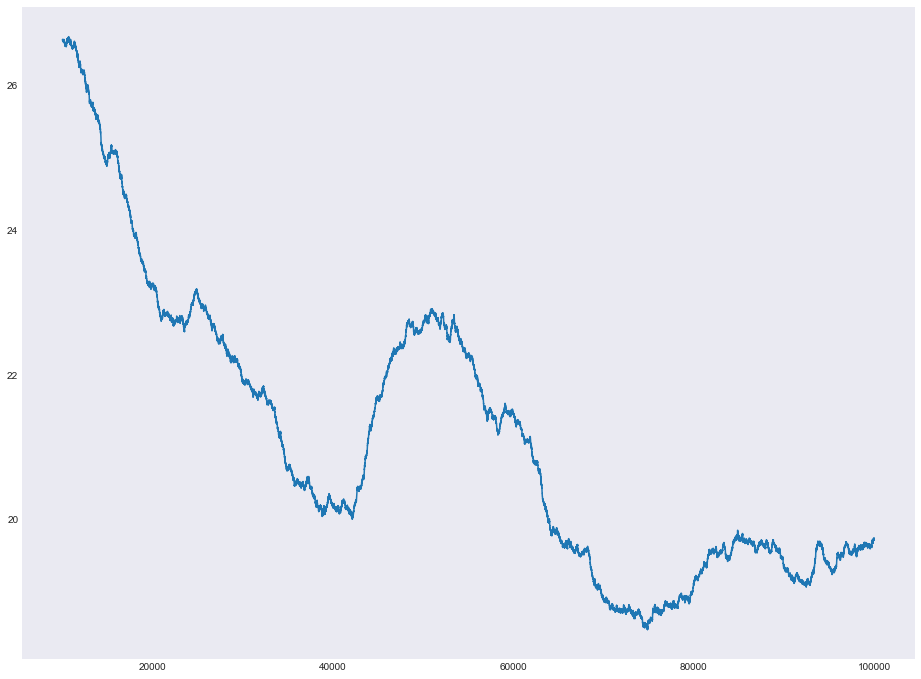

In [19]:
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [20]:
print('Mean of the loss function on the last 10k train samples: %0.2f' % np.mean(model._loss[-35000:-25000]))

Mean of the loss function on the last 10k train samples: 19.73


## 3. Тестирование модели

В базовой модели первые 100 000 строк используются для обучения, а оставшиеся – для тестирования. Как вы можете заметить, значение отрицательного логарифмического правдоподобия не очень информативно, хоть и позволяет сравнивать разные модели. В качестве четвертого задания вам необходимо модифицировать базовую модель таким образом, чтобы метод `iterate_file` возвращал значение _точности_ на тестовой части набора данных. 

Точность определим следующим образом:
- считаем, что тег у вопроса присутствует, если спрогнозированная вероятность тега больше 0.9
- точность одного примера расчитывается как [коэффициент Жаккара](https://ru.wikipedia.org/wiki/Коэффициент_Жаккара) между множеством настоящих тегов и предсказанных моделью
  - например, если у примера настоящие теги ['html', 'jquery'], а по версии модели ['ios', 'html', 'java'], то коэффициент Жаккара будет равен |['html', 'jquery'] $\cap$ ['ios', 'html', 'java']| / |['html', 'jquery'] $\cup$ ['ios', 'html', 'java']| = |['html']| / |['jquery', 'ios', 'html', 'java']| = 1/4
- метод `iterate_file` возвращает **среднюю** точность на тестовом наборе данных

In [10]:
def jakkar(true_tags,predicted_tags):
    equal_tags = []
    for tag in true_tags:
        if tag in predicted_tags:
            equal_tags.append(tag)
    len_all = (len(true_tags) - len(equal_tags)) + len(predicted_tags)
    jakkar_out = len(equal_tags)/len_all 
    return jakkar_out          

In [44]:
# Обновите определение класса LogRegressor
class LogRegressor1():
    
    """Конструктор
    
    Параметры
    ----------
    tags : list of string, default=top_tags
        список тегов
    """
    
    
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        log_out = []
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                true_tags = []
                predicted_tags = []
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    if(y == 1):
                        true_tags.append(tag)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # инициализируем z
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]            
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]]  
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = float(1.0 / float(1.0 + sigmoid_dec(z)))
                    if(sigma > 0.9):
                        predicted_tags.append(tag)
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    #if y == 1:
                    #    error = y * math.log(sigma)
                    #elif y == 0:
                    #    error = (1.0-y) * math.log(1.0-sigma)
                    #smpl_err = float(-1.0 * error)
                    #smpl_err = -1.0 * error
                    #sample_loss += smpl_err
                    sample_loss += -1.0 * (y*math.log(log_sigma(sigma,tolerance)) + (1.0 - y)*math.log(log_sigma((1.0 - sigma),tolerance)))
                   
                    #add_loss = logloss(y, sigma, tolerance)
                    #sample_loss += add_loss
                    #sample_loss += float(y * math.log(sigma))
                    #sample_loss += smpl_err
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        dLdw = float(-1.0 *(sigma - y))
                        #dLdw = float((self._vocab[word] - sample_loss))
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                        
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                    
                    
                n += 1
                        
                log_out.append(jakkar(true_tags,predicted_tags))
                self._loss.append(sample_loss)
        return np.mean(log_out)       
                     

In [28]:
model = LogRegressor1()
acc = model.iterate_file()
# выведем полученное значение с точностью до двух знаков
print('%0.2f' % acc)

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))


0.57


## 4. $L_2$-регуляризация

В качестве пятого задания вам необходимо добавить в класс `LogRegressor` поддержку $L_2$-регуляризации. В методе `iterate_file` должен появиться параметр `lmbda=0.01` со значением по умолчанию. С учетом регуляризации новая функция стоимости примет вид:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \frac{\lambda}{2} \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2
\end{array}$$

Градиент первого члена суммы мы уже вывели, а для второго он имеет вид:

$$\large \begin{array}{rcl}
\frac{\partial}{\partial w_{ki}} \frac{\lambda}{2} R\left(W\right) &=& \lambda w_{ki}
\end{array}$$

Если мы на каждом примере будем делать честное обновление всех весов, то все очень замедлится, ведь нам придется на каждой итерации пробегать по всем словам словаря. В ущерб теоретической корректности мы используем грязный трюк: будем регуляризировать только те слова, которые присутствуют в текущем предложении. Не забывайте, что смещение (bias) не регуляризируется. `sample_loss` тоже должен остаться без изменений.

Замечание:
- не забудьте, что нужно учитывать регуляризацию слова в градиентном шаге только один раз
- условимся, что учитываем регуляризацию только при первой встрече слова
- если бы мы считали сначала bag-of-words, то мы бы в цикле шли по уникальным словам, но т.к. мы этого не делаем, приходится выкручиваться (еще одна жертва богу online-моделей)

In [54]:
# Обновите определение класса LogRegressor
class LogRegressor2():
    
    """Конструктор
    
    Параметры
    ----------
    tags : list of string, default=top_tags
        список тегов
    """
    
    
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.01):
        
        self._loss = []
        log_out = []
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                true_tags = []
                predicted_tags = []
                # значение функции потерь для текущего примера
                sample_loss = 0
                l_loss = 0
                itr = 0
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    if(y == 1):
                        true_tags.append(tag)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # инициализируем z
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]            
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]]  
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = float(1.0 / float(1.0 + sigmoid_dec(z)))
                    if(sigma > 0.9):
                        predicted_tags.append(tag)
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    #if y == 1:
                    #    error = y * math.log(sigma)
                    #elif y == 0:
                    #    error = (1.0-y) * math.log(1.0-sigma)
                    #smpl_err = float(-1.0 * error)
                    #smpl_err = -1.0 * error
                    #sample_loss += smpl_err
                    #l_loss += float(lmbda/2)*math.pow((self._w[tag][self._vocab[word]]),2)
                    sample_loss += -1.0 * (y*math.log(log_sigma(sigma,tolerance)) + (1.0 - y)*math.log(log_sigma((1.0 - sigma),tolerance))) 
                    #add_loss = logloss(y, sigma, tolerance)
                    #sample_loss += add_loss
                    #sample_loss += float(y * math.log(sigma))
                    #sample_loss += smpl_err
                    # если мы все еще в тренировочной части, то обновим параметры
                    
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        if itr == 0:
                            Ldl = lmbda * self._w[tag][self._vocab[word]]
                            dLdw = float(-1.0 *(sigma - y)) + Ldl
                            for word in sentence:                        
                                self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        else:
                            dLdw = float(-1.0 *(sigma - y))
                            for word in sentence:                        
                                self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                            self._b[tag] -= -learning_rate*dLdw
                    itr += 1
                
                n += 1
                        
                log_out.append(jakkar(true_tags,predicted_tags))
                self._loss.append(sample_loss)
        return np.mean(log_out)       
                     

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))


0.52


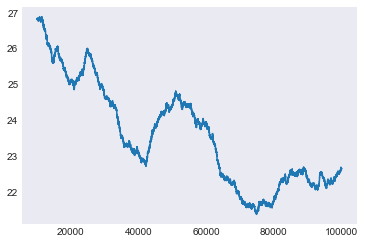

In [55]:
model = LogRegressor2()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

## 5. Регуляризация ElasticNet , реализация

В качестве седьмой задачи вам предлается изменить класс `LogRegressor` таким образом, чтобы метод `iterate_file` принимал два параметра со значениями по умолчанию `lmbda=0.0002` и `gamma=0.1`. Сделайте один проход по датасету с включенной `ElasticNet`-регуляризацией и заданными значениями по умолчанию и ответьте на вопрос.

In [59]:
# Обновите определение класса LogRegressor
class LogRegressor3():
    
    """Конструктор
    
    Параметры
    ----------
    tags : list of string, default=top_tags
        список тегов
    """
    
    
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.0002,
                     gamma=0.1):
        
        self._loss = []
        log_out = []
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                true_tags = []
                predicted_tags = []
                # значение функции потерь для текущего примера
                sample_loss = 0
                l_loss = 0
                itr = 0
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    if(y == 1):
                        true_tags.append(tag)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # инициализируем z
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]            
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]]  
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = float(1.0 / float(1.0 + sigmoid_dec(z)))
                    if(sigma > 0.9):
                        predicted_tags.append(tag)
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    #if y == 1:
                    #    error = y * math.log(sigma)
                    #elif y == 0:
                    #    error = (1.0-y) * math.log(1.0-sigma)
                    #smpl_err = float(-1.0 * error)
                    #smpl_err = -1.0 * error
                    #sample_loss += smpl_err
                    #l_loss += float(lmbda/2)*math.pow((self._w[tag][self._vocab[word]]),2)
                    sample_loss += -1.0 * (y*math.log(log_sigma(sigma,tolerance)) + (1.0 - y)*math.log(log_sigma((1.0 - sigma),tolerance))) 
                    #add_loss = logloss(y, sigma, tolerance)
                    #sample_loss += add_loss
                    #sample_loss += float(y * math.log(sigma))
                    #sample_loss += smpl_err
                    # если мы все еще в тренировочной части, то обновим параметры
                    
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        if itr == 0:
                            Ldl = float(lmbda*((2*gamma * self._w[tag][self._vocab[word]]) + (1 - gamma)*np.sign(self._w[tag][self._vocab[word]])))
                            dLdw = float(-1.0 *(sigma - y)) + Ldl
                            for word in sentence:                        
                                self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        else:
                            dLdw = float(-1.0 *(sigma - y))
                            for word in sentence:                        
                                self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                            self._b[tag] -= -learning_rate*dLdw
                    itr += 1
                
                n += 1
                        
                log_out.append(jakkar(true_tags,predicted_tags))
                self._loss.append(sample_loss)
        return np.mean(log_out)       

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))


0.57


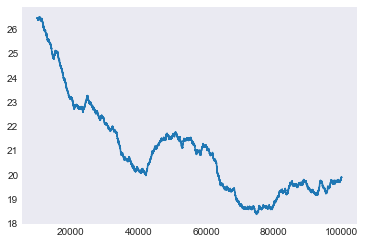

In [60]:
model = LogRegressor3()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

## 6. Самые важные слова для тега

Прелесть линейных моделей в том, что они легко интерпретируемы. Вам предлагается вычислить, какие слова вносят наибольший вклад в вероятность появления каждого из тегов. А затем ответьте на контрольный вопрос.

In [61]:
model = LogRegressor3()
acc = model.iterate_file()

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))

In [62]:
model._vocab_inv = dict([(v, k) for (k, v) in model._vocab.items()])

for tag in model._tags:
    print(tag, ':', ', '.join([model._vocab_inv[k] for (k, v) in 
                               sorted(model._w[tag].items(), 
                                      key=lambda t: t[1], 
                                      reverse=True)[:5]]))    

javascript : javascript, x20, 125, 3, x30
php : php, _post, x5c, echo, 125
java : dx, println, java, spring, servlet
c++ : avrf, c++, std, cout, const
android : android, activity, art, arm, imgsrv
html : 3, html, br, nbsp, span
ios : ios, dylib, nsstring, nil, uiview
c# : writeline, binding, net, linq, sender
python : python, def, py, django, np
jquery : jquery, ready, ajax, val, sdf


## 7. Сокращаем размер словаря
Сейчас количество слов в словаре – 519290, если бы это была выборка из 10 миллионов вопросов с сайта StackOverflow, то размер словаря был бы миллионов 10. Регуляризировать модель можно не только изящно математически, но и топорно, например, ограничить размер словаря. Вам предоставляется возможность внести следующие изменения в класс `LogRegressor`:
- добавить в метод `iterate_file` еще один аргумент со значением по умолчанию `update_vocab=True`
- при `update_vocab=True` разрешать добавлять слова в словарь в режиме обучения
- при `update_vocab=False` игнорировать слова не из словаря
- добавить в класс метод `filter_vocab(n=10000)`, который оставит в словаре только топ-n самых популярных слов, используя данные из ``train``

In [17]:
# Обновите определение класса LogRegressor
class LogRegressor4():
    
    """Конструктор
    
    Параметры
    ----------
    tags : list of string, default=top_tags
        список тегов
    """
    def filter_vocab(self, n = 10000):
        sorted(self._freq.items(), key=lambda x: x[1], reverse = True)
        for word in self._vocab:
            if word not in self._freq:
                del self._vocab[word]
    
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.0002,
                     gamma=0.1,
                     update_vocab=True):
        
        self._loss = []
        log_out = []
        self._freq = {}
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                true_tags = []
                predicted_tags = []
                # значение функции потерь для текущего примера
                sample_loss = 0
                l_loss = 0
                itr = 0
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    if(y == 1):
                        true_tags.append(tag)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # инициализируем z
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]            
                    for word in sentence:
    # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        else:
                            if update_vocab:
                                if word not in self._vocab:
                                    self._vocab[word] = len(self._vocab)
                                self._freq[word] = self._freq.get(word, 0) + 1
                        z += self._w[tag][self._vocab[word]]
                   
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = float(1.0 / float(1.0 + sigmoid_dec(z)))
                    if(sigma > 0.9):
                        predicted_tags.append(tag)
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    #if y == 1:
                    #    error = y * math.log(sigma)
                    #elif y == 0:
                    #    error = (1.0-y) * math.log(1.0-sigma)
                    #smpl_err = float(-1.0 * error)
                    #smpl_err = -1.0 * error
                    #sample_loss += smpl_err
                    #l_loss += float(lmbda/2)*math.pow((self._w[tag][self._vocab[word]]),2)
                    sample_loss += -1.0 * (y*math.log(log_sigma(sigma,tolerance)) + (1.0 - y)*math.log(log_sigma((1.0 - sigma),tolerance))) 
                    #add_loss = logloss(y, sigma, tolerance)
                    #sample_loss += add_loss
                    #sample_loss += float(y * math.log(sigma))
                    #sample_loss += smpl_err
                    # если мы все еще в тренировочной части, то обновим параметры
                    
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        if itr == 0:
                            Ldl = float(lmbda*((2*gamma * self._w[tag][self._vocab[word]]) + (1 - gamma)*np.sign(self._w[tag][self._vocab[word]])))
                            dLdw = float(-1.0 *(sigma - y)) + Ldl
                            for word in sentence:                        
                                self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        else:
                            dLdw = float(-1.0 *(sigma - y))
                            for word in sentence:                        
                                self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                            self._b[tag] -= -learning_rate*dLdw
                    itr += 1
                
                n += 1
                        
                log_out.append(jakkar(true_tags,predicted_tags))
                self._loss.append(sample_loss)
        return np.mean(log_out)       

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))


0.57


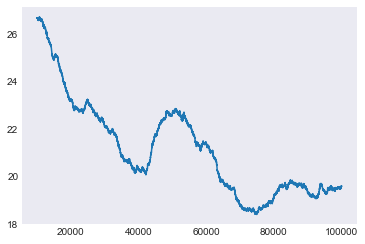

In [18]:
model = LogRegressor4()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [19]:
# оставим только топ 10 000 слов
model.filter_vocab(n=10000)

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))


0.70


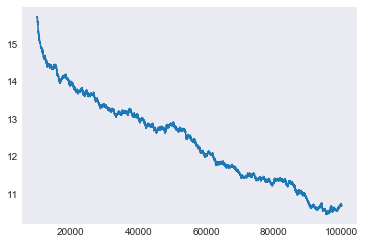

In [20]:
# сделаем еще одну итерацию по датасету, уменьшив скорость обучения в 10 раз
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

## 8. Прогнозирование тегов для новых вопросов

В завершение этого задания вам предлагается реализовать метод `predict_proba`, который принимает строку, содержащую вопрос, а возвращает список предсказанных тегов вопроса с их вероятностями.

In [53]:
# Обновите определение класса LogRegressor
class LogRegressor5():
    
    """Конструктор
    
    Параметры
    ----------
    tags : list of string, default=top_tags
        список тегов
    """
    def predict_proba(self, sentence):        
        sentence = sentence.split(' ')
        for tag in self._tags:
            z = self._b[tag] 
            for word in sentence:
                if word in self._vocab:
                    z += self._w[tag][self._vocab[word]]
                    
            sigma = float(1.0 / float(1.0 + sigmoid_dec(z)))   
                
            self._result[tag] = sigma
        return self._result
    
    
    def filter_vocab(self, n = 10000):
        sorted(self._freq.items(), key=lambda x: x[1], reverse = True)
        for word in self._vocab:
            if word not in self._freq:
                del self._vocab[word]
    
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.0002,
                     gamma=0.1,
                     update_vocab=True):
        
        self._loss = []
        log_out = []
        self._result = {}
        self._freq = {}
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                true_tags = []
                predicted_tags = []
                # значение функции потерь для текущего примера
                sample_loss = 0
                l_loss = 0
                itr = 0
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    if(y == 1):
                        true_tags.append(tag)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # инициализируем z
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]            
                    for word in sentence:
    # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        else:
                            if update_vocab:
                                if word not in self._vocab:
                                    self._vocab[word] = len(self._vocab)
                                self._freq[word] = self._freq.get(word, 0) + 1
                        z += self._w[tag][self._vocab[word]]
                   
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = float(1.0 / float(1.0 + sigmoid_dec(z)))
                    if(sigma > 0.9):
                        predicted_tags.append(tag)
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    #if y == 1:
                    #    error = y * math.log(sigma)
                    #elif y == 0:
                    #    error = (1.0-y) * math.log(1.0-sigma)
                    #smpl_err = float(-1.0 * error)
                    #smpl_err = -1.0 * error
                    #sample_loss += smpl_err
                    #l_loss += float(lmbda/2)*math.pow((self._w[tag][self._vocab[word]]),2)
                    sample_loss += -1.0 * (y*math.log(log_sigma(sigma,tolerance)) + (1.0 - y)*math.log(log_sigma((1.0 - sigma),tolerance))) 
                    #add_loss = logloss(y, sigma, tolerance)
                    #sample_loss += add_loss
                    #sample_loss += float(y * math.log(sigma))
                    #sample_loss += smpl_err
                    # если мы все еще в тренировочной части, то обновим параметры
                    
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        if itr == 0:
                            Ldl = float(lmbda*((2*gamma * self._w[tag][self._vocab[word]]) + (1 - gamma)*np.sign(self._w[tag][self._vocab[word]])))
                            dLdw = float(-1.0 *(sigma - y)) + Ldl
                            for word in sentence:                        
                                self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        else:
                            dLdw = float(-1.0 *(sigma - y))
                            for word in sentence:                        
                                self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                            self._b[tag] -= -learning_rate*dLdw
                    itr += 1
                
                n += 1
                        
                log_out.append(jakkar(true_tags,predicted_tags))
                self._loss.append(sample_loss)
        return np.mean(log_out)       

In [54]:
model = LogRegressor5()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
model.filter_vocab(n=10000)
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))


0.57


HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))


0.70


In [55]:
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty " + 
            "level").lower().replace(',', '')
stc = " my background: I have done basic programming in .Net,C/C++,Python and PHP "

In [56]:
sorted(model.predict_proba(sentence).items(), 
       key=lambda t: t[1], reverse=True)

[('ios', 1.0),
 ('php', 0.9998258233597768),
 ('android', 0.9988220414079209),
 ('java', 5.55017953366395e-21),
 ('c++', 3.0332041980003384e-27),
 ('javascript', 1.755788909837654e-27),
 ('python', 1.172836392128413e-27),
 ('html', 3.4905439576942624e-29),
 ('c#', 1.053341793173805e-37),
 ('jquery', 2.8918959184220924e-56)]

In [52]:
model.predict_proba(stc)

{'android': 2.9723800299974457e-06,
 'c#': 2.3084315461385785e-06,
 'c++': 1.5967149824547278e-09,
 'html': 0.0,
 'ios': 2.2408587208033737e-07,
 'java': 0.013498284776565561,
 'javascript': 4.4245718200386364e-11,
 'jquery': 0.0,
 'php': 3.4195268838743687e-10,
 'python': 9.25388654593462e-11}